# Map visualizations (Matt)

In [38]:
# imports and setup
from   ast import literal_eval
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from   cartopy.io.img_tiles import MapboxTiles
from   collections import Counter, defaultdict
import matplotlib.pyplot as plt
import os
import pandas as pd
import string
from   unidecode import unidecode

data_dir = os.path.join('..', 'data')
derived_dir = os.path.join(data_dir, 'derived')
fig_dir = os.path.join('..', 'figures')

conlit_input_file = 'CONLIT_CharData_AP_MW_11.csv.gz'
early_input_file = 'EARLY_CharData_AP_MW_11.csv.gz'

mapbox_key_file = '/Users/mw966/Library/CloudStorage/GoogleDrive-mw966@cornell.edu/My Drive/Private/mapbox-api-key.txt'

## Load CONLIT data

In [5]:
def string_to_list(x):
    lst = literal_eval(x.replace(', nan', "', ZZZZ'").replace('[nan, ', "'['").replace(', nan]', "']'"))
    return [i for i in lst if i != 'ZZZZ']

conlit = pd.read_csv(
    os.path.join(derived_dir, conlit_input_file), 
    index_col='book_id',
    converters={
        'gpe_places': string_to_list,
        'nongpe_places': string_to_list,
        'all_places': string_to_list,
        'gpe_sequences': string_to_list
    },
)
conlit = conlit.fillna('')

## Wilkens geo data

In [6]:
# regularize data to wilkens geo format
punctuation_to_space = str.maketrans({key:' ' for key in string.punctuation})

def regularize_string(place_string):
    return(unidecode(' '.join(place_string.translate(punctuation_to_space).lower().split())))

wi = pd.read_csv(
    os.path.join('..', '..', 'toponyms', 'geo.tsv.gz'),
    sep='\t',
    low_memory=False,
)
wi = wi.loc[wi.lang=='en']
wi.set_index('text_string', inplace=True)

# hand review data
hand = pd.read_csv(
    os.path.join('..', '..', 'toponyms', 'us_handreview.tsv'),
    sep='\t',
    index_col='text_string'
)

# restore some items from C19 hand review
hand.loc[
    [
        'hollywood', 
        'dallas', 
        'florence', 
        'kingston',
        'berkeley', 
        'queens', 
        'phoenix', 
        'woodstock', 
        'surrey',
        'orlando'
    ], 
    'ignore'
] = 0

# improve alises
hand.loc['kingston', 'alias_to'] = 'kingston jamaica'
hand.loc['baltic', ['ignore', 'alias_to']] = [0, 'baltic sea']

# alias places
for original_place, alias_to in hand.loc[(~hand.alias_to.isna()) & (~hand.ignore.equals(1)) & (hand.alias_to.isin(wi.index)), 'alias_to'].items():
    wi.loc[original_place] = wi.loc[alias_to]
    
# drop ignored places
wi.drop(hand.loc[hand.ignore==1].index, inplace=True, errors='ignore')

In [7]:
# drop unused places
wi_gpes = Counter()
for sequence in conlit.gpe_sequences:
    wi_gpes.update([regularize_string(i) for i in sequence])
wi.drop(wi.loc[~wi.index.isin(wi_gpes)].index, inplace=True, errors='ignore')

## Mapping

In [31]:
def get_lat_lon(place_string, geo_data=wi, extended=False):
    '''Assumes lookup string has been regularized if necessary'''
    try:
        if extended:
            return(geo_data.loc[place_string, ['lat', 'lon', 'country_short', 'admin_1_std', 'location_type']])
        else:
            return(geo_data.loc[place_string, ['lat', 'lon']])
    except (ValueError, KeyError):
        return(None)

def get_route(list_of_places, geo_data=wi):
    '''Takes a list of locations, returns a list of lat-lon tuples'''
    route = []
    seq = [regularize_string(i) for i in list_of_places if regularize_string(i) in geo_data.index]
    for place in list_of_places:
        route.append(get_lat_lon(place, geo_data=geo_data))
    return(pd.DataFrame(route))

In [48]:
test_route = get_route(['new york city', 'los angeles', 'europe'])

In [49]:
# Function to generate bubble maps of arbitrary data
try:
    mapbox_key = open(mapbox_key_file).read().strip()
except:
    print('Cannot get MapBox API key. This will go badly.')

def routemap(
    lats, 
    lons, 
    figsz=(12,6), 
    color='red', 
    extent=[-170, 170, -60, 80], 
    proj=ccrs.Robinson(), 
    hires=False, 
    name='map'
):
    '''Takes lists of lats and lons.
    figsz is a tuple in inches, e.g.: (12, 6)
    extent is a list of degrees for viewport, e.g.: [-170, 170, -60, 80]
    proj is a cartopy projection: ccrs.Robinson() or ccrs.OSGB()
    hires is boolean. False for world maps, true for country maps.
    Saves output file and displays map, but returns nothing.
    '''
    fig = plt.figure(figsize=figsz)
    ax = plt.axes(projection=proj)
    
    if extent:
        ax.set_extent(extent)
    #sizes      = [i/50 for i in sizes]

    plt.plot(lons, lats, #linewidths=1,
                color=color, marker=None, alpha=0.4, transform=ccrs.Geodetic())
    if hires:
        coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')
        ax.add_feature(coast, edgecolor='black')
    else:
        ax.add_feature(cfeature.COASTLINE, linewidth=0.6, edgecolor='dimgray', alpha=1.0)
        ax.add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor='gray')
    fig.canvas.draw()
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, name)+'.png', dpi=300)

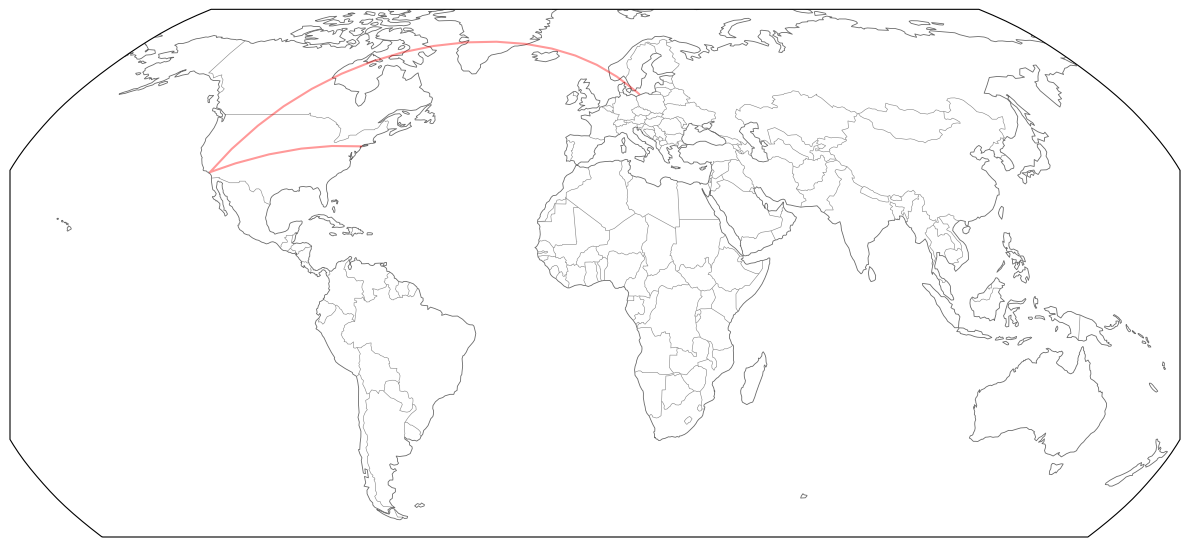

In [50]:
routemap(test_route['lat'], test_route['lon'])